# Gaussian process

All models that we encounter up to know provide a point-estimate at the moment of prediction. However, none of the models (apart the `QuantileRegression` provide some confidence interval regarding the provided predictions.

A family of model known as Gaussian Process allows to obtain such information. In this notebook, we will present the difference of this model compare to models that we already presented.

Let's start by generating a toy dataset.

In [13]:
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

In [14]:
import seaborn as sns
sns.set_context("poster")

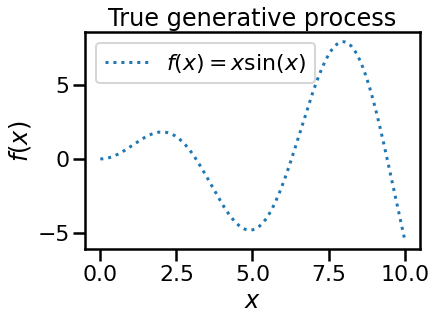

In [15]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

## Example with noise-free target

In this first example, we will use the true generative process without
adding any noise. For training the Gaussian Process regression, we will only
select few samples.

In [18]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

The advantage of a Gaussian kernel is that we can craft a kernel by hand and compose together some base kernels. Here, we will use a radial basis function (RBF) kernel and a constant parameter to fit the amplitude.

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

In the previous method that we presented, we had a single model where we usually try to find the optimal parameters that best fit the dataset. In Gaussian Process, the paradigm is diffrerent: we deal with a distribution of models. With have some *apriori* defined by the prior distribution of the models. The training set will be combined with this prior to provide us a posterior distribution of models.

First, let's have a look at the prior distribution of our Gaussian process.

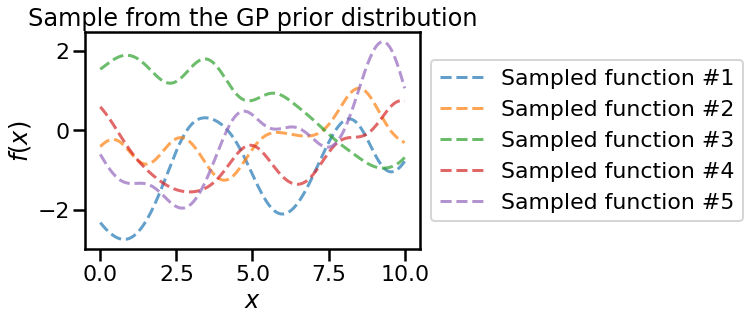

In [27]:
y_samples = gaussian_process.sample_y(X, n_samples=5)

for idx, single_prior in enumerate(y_samples.T):
    plt.plot(
        X.ravel(),
        single_prior,
        linestyle="--",
        alpha=0.7,
        label=f"Sampled function #{idx + 1}",
    )

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Sample from the GP prior distribution")

The sample from the prior distribution are just random realisation initially. They are far from fitting our true generative model. However, from all the sample, we can indeed have a distribution of models. In this case, we can plot the mean and the 95% confidence interval.

In [29]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

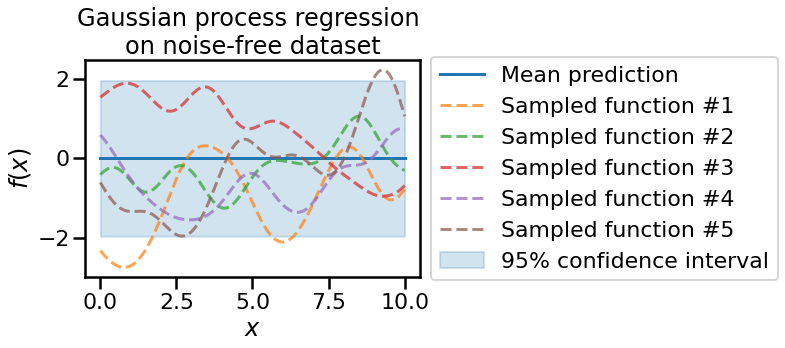

In [33]:
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.2,
    label=r"95% confidence interval",
    color="tab:blue",
)

for idx, single_prior in enumerate(y_samples.T):
    plt.plot(
        X.ravel(),
        single_prior,
        linestyle="--",
        alpha=0.7,
        label=f"Sampled function #{idx + 1}",
    )


plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("GP prediction using only prior distribution")

Thus, if we plot the true generative process and the prediction, we are far to be happy about our modelisation.

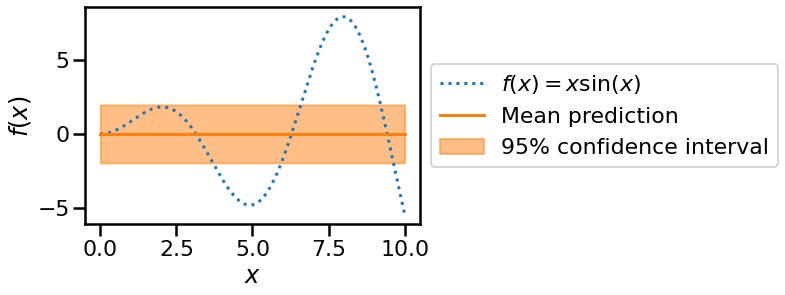

In [37]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
    color="tab:orange",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("$x$")
_ = plt.ylabel("$f(x)$")

Now, we fit a Gaussian process on these few training samples to see how they will influence the posterior distribution.

In [38]:
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

After fitting our model, we see that the hyperparameters of the kernel have been optimized. Now, we will use our kernel to compute the mean prediction of the full dataset and plot the 95% confidence interval.

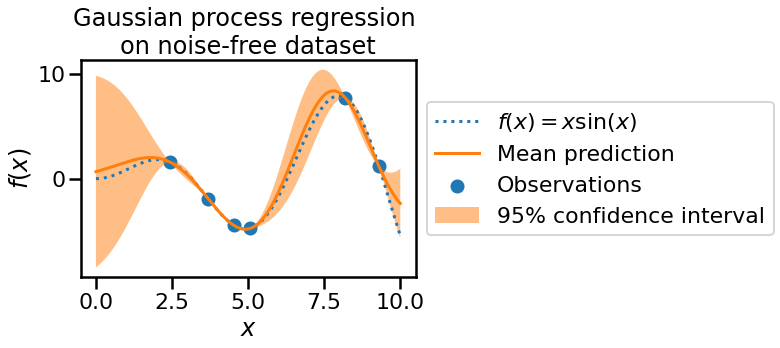

In [39]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression \non noise-free dataset")

We see that for a prediction made on a data point close to the one from the
training set, the 95% confidence has a small amplitude. Whenever a sample
falls far from training data, our model's prediction is less accurate and the
model prediction is less precise (higher uncertainty).

## Example with noisy targets

We can repeat a similar experiment adding an additional noise to the target
this time. It will allow seeing the effect of the noise on the fitted model.

We add some random Gaussian noise to the target with an arbitrary
standard deviation.

In [40]:
dy = 0.5 + 1.0 * rng.random_sample(y_train.shape)
y_train_noisy = y_train + rng.normal(0, dy)

We create a similar Gaussian process model. In addition to the kernel, this
time, we specify the parameter `alpha` which can be interpreted as the
variance of a Gaussian noise.

In [41]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=dy ** 2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

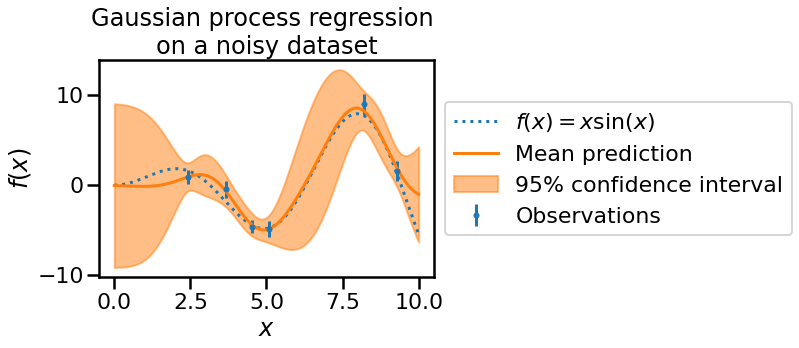

In [42]:
# %%
# Let's plot the mean prediction and the uncertainty region as before.
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    dy,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression \non a noisy dataset")